In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from models import Discriminator, Generator
import os
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [3]:
# CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=transform, download=True
)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

Files already downloaded and verified


In [4]:
def calculate_gradient_norm(model):
    total_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

def train_model(latent_size=100, num_epochs=100, critic_iterations=5, clip_value=0.01, save_epochs=50, model_path = "./saved_models", progress_path = "./progress"):
    generator = Generator(latent_size).to('cuda')
    critic = Discriminator().to('cuda')

    optimizer_G = optim.RMSprop(generator.parameters(), lr=0.00005)
    optimizer_C = optim.RMSprop(critic.parameters(), lr=0.00005)
    
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    if not os.path.exists(progress_path):
        os.makedirs(progress_path)
    if not os.path.exists(f"{progress_path}/random"):
        os.makedirs(f"{progress_path}/random")
    if not os.path.exists(f"{progress_path}/static"):
        os.makedirs(f"{progress_path}/static")
        
    z_static = torch.randn(8, latent_size, 1, 1).to(device)
    
    training_metrics_df = pd.DataFrame(columns=["epoch", "discriminator_loss", "generator_loss", "generator_grad_norm", "discriminator_grad_norm"])

    # Training loop
    lowest_critic_loss = np.inf
    for epoch in range(num_epochs):
        grad_G = []
        grad_C = []
        for _, (real_images, _) in enumerate(tqdm(train_loader,  desc=f'Epoch {epoch}/{num_epochs}')):
            batch_size = real_images.size(0)
            real_images = real_images.cuda()

            # Train critic
            for _ in range(critic_iterations):
                optimizer_C.zero_grad()

                z = torch.randn(batch_size, latent_size, 1, 1).cuda()

                fake_images = generator(z)

                real_scores = critic(real_images)
                fake_scores = critic(fake_images.detach())

                critic_loss = -torch.mean(real_scores) + torch.mean(fake_scores)

                critic_loss.backward()
                optimizer_C.step()
                
                grad_C.append(calculate_gradient_norm(critic))

                # Clip critic weights
                for param in critic.parameters():
                    param.data.clamp_(-clip_value, clip_value)

            # Train generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_size, 1, 1).cuda()
            fake_images = generator(z)
            fake_scores = critic(fake_images)
            generator_loss = -torch.mean(fake_scores)
            generator_loss.backward()
            optimizer_G.step()
            
            grad_G.append(calculate_gradient_norm(generator))

        print(
            f"Epoch [{epoch}/{num_epochs}], "
            f"Discriminator Loss: {critic_loss.item():.4f}, "
            f"Generator Loss: {generator_loss.item():.4f}"
        )
        
        if len(training_metrics_df) == 0:
            training_metrics_df = pd.DataFrame({"epoch": [epoch], "discriminator_loss": [critic_loss.item()], "generator_loss": [generator_loss.item()], 
                                                "generator_grad_norm": [np.mean(grad_G)], "discriminator_grad_norm": [np.mean(grad_C)]})
        else:
            new_row = pd.DataFrame({"epoch": [epoch], "discriminator_loss": [critic_loss.item()], "generator_loss": [generator_loss.item()], 
                                    "generator_grad_norm": [np.mean(grad_G)], "discriminator_grad_norm": [np.mean(grad_C)]})
            training_metrics_df = pd.concat([training_metrics_df, new_row], ignore_index=True)
        training_metrics_df.to_csv(f"{model_path}/training_metrics.csv", index=False)
        if critic_loss < lowest_critic_loss:
            lowest_critic_loss = critic_loss
            print("Saving optimal...")
            torch.save(generator.state_dict(), f"{model_path}/generator_optimal.pth")
            torch.save(critic.state_dict(), f"{model_path}/discriminator_optimal.pth")

        if epoch % save_epochs == 0:
            print("Saving epoch...")
            torch.save(generator.state_dict(), f"{model_path}/generator_{epoch}.pth")
            torch.save(critic.state_dict(), f"{model_path}/discriminator_{epoch}.pth")
            with torch.no_grad():
                z = torch.randn(8, latent_size, 1, 1).to(device)
                generated_images = generator(z)
                generated_images = generated_images.cpu().detach()
                generated_images = generated_images.view(-1, 3, 32, 32)
                generated_images = generated_images / 2 + 0.5  # Unnormalize
                plt.figure(figsize=(8, 4))
                for i in range(generated_images.size(0)):
                    plt.subplot(2, 4, i+1)
                    plt.imshow(np.transpose(generated_images[i], (1, 2, 0)))
                    plt.axis('off')
                plt.tight_layout()
                plt.savefig(f"{progress_path}/random/generated_images_epoch_{epoch}.png")
                plt.close()
                
                generated_images = generator(z_static)
                generated_images = generated_images.cpu().detach()
                generated_images = generated_images.view(-1, 3, 32, 32)
                generated_images = generated_images / 2 + 0.5  # Unnormalize
                plt.figure(figsize=(8, 4))
                for i in range(generated_images.size(0)):
                    plt.subplot(2, 4, i+1)
                    plt.imshow(np.transpose(generated_images[i], (1, 2, 0)))
                    plt.axis('off')
                plt.tight_layout()
                plt.savefig(f"{progress_path}/static/generated_images_epoch_{epoch}.png")
                plt.close()
    print("Saving...")
    torch.save(generator.state_dict(), f"{model_path}/generator_final.pth")
    torch.save(critic.state_dict(), f"{model_path}/discriminator_final.pth")
    return generator, critic

In [5]:
def display_test_samples(generator, device, latent_size=100, num_samples=50, n_rows=5, n_cols=10):
    generator.eval()

    with torch.no_grad():
        noise = torch.randn(num_samples, latent_size, 1, 1).to(device)
        fake_images = generator(noise).view(-1, 3, 32, 32)
        fake_images = fake_images.cpu().numpy()

        _, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
        for i, ax in enumerate(axes.flat):
            image_to_show = np.transpose(fake_images[i], (1, 2, 0))
            ax.axis("off")

            # Normalize the image to [0, 1]
            image_to_show = (image_to_show + 1) / 2

            # Display the image
            ax.imshow(image_to_show)
        plt.tight_layout()
        plt.savefig("./final_images/generated_samples.png")
        plt.show()
        
def plot_loss(training_metrics_df):
    plt.figure(figsize=(12, 6))
    plt.plot(training_metrics_df["epoch"], -training_metrics_df["discriminator_loss"], label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
def plot_grad_norm(training_metrics_df):
    plt.figure(figsize=(12, 6))
    plt.plot(training_metrics_df["epoch"], training_metrics_df["generator_grad_norm"], label="Generator Grad Norm")
    plt.plot(training_metrics_df["epoch"], training_metrics_df["discriminator_grad_norm"], label="Discriminator Grad Norm")
    plt.xlabel("Epoch")
    plt.ylabel("Gradient Norm")
    plt.legend()
    plt.show()

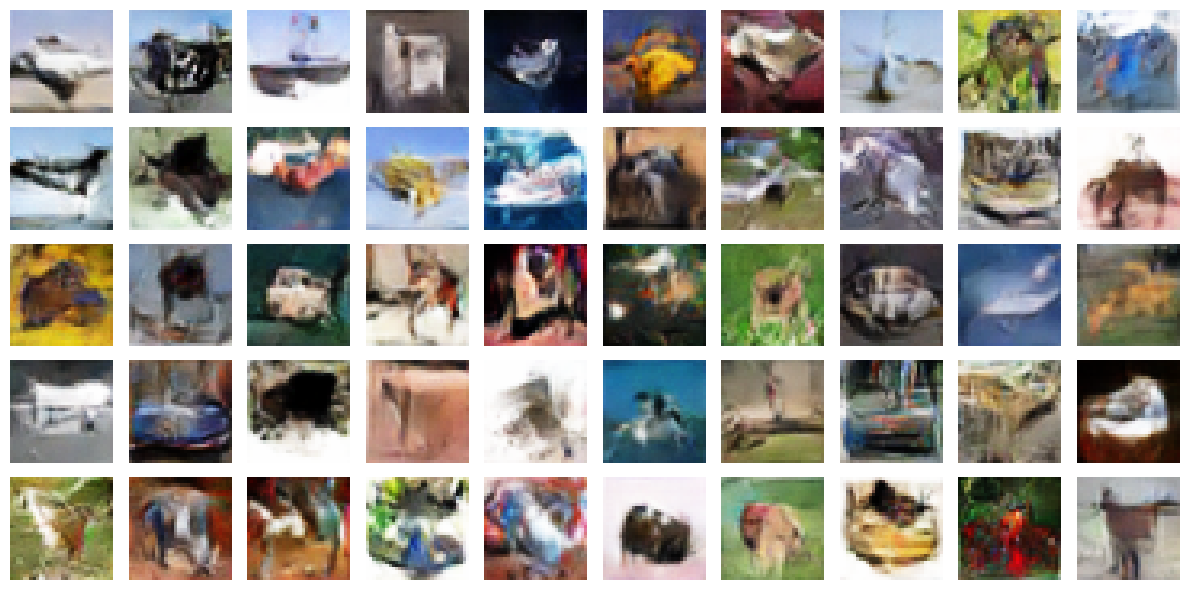

In [6]:
generator = Generator(100).to(device)
generator.load_state_dict(torch.load("final_models/final_generator.pth", map_location=device))

display_test_samples(generator, device)

In [ ]:
generator, critic = train_model(num_epochs=1000, save_epochs=50, model_path="./saved_models_track_grad", progress_path="./progress_track_grad")

In [ ]:
df = pd.read_csv("./saved_models_track_grad/training_metrics.csv")
plot_loss(df)